In [1]:
import numpy as np
import cv2 as cv
import os
from matplotlib import pyplot as plt
from typing import List

In [2]:
def find_format(path: str, file_format: str) -> List[str]:
    """
    Recursively walks through folders and files in path looking for .<file_format> -formatted files
    :param path: path to search directory;
    :param file_format: format of the file to search for;
    :return: list of pathes to found files.
    """
    lPathes = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(file_format):
                lPathes.append(os.path.join(root, file))
    return lPathes

In [3]:
def apply_morphology(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Applying morphological operations - opening and closing to get 
    rid of lines on checkered paper, which are useless at this point.
    :param image: cv-image;
    :param kernel: kernel to perform morphological opening and closing;
    :return: image fistly opened then closed.
    """
    opened_image = cv.morphologyEx(image, cv.MORPH_OPEN, kernel)
    closed_image = cv.morphologyEx(opened_image, cv.MORPH_CLOSE, kernel)
    return closed_image

In [4]:
def get_nth_biggest_area_contour(mask: np.ndarray, n: int) -> np.ndarray:
    """
    Finds nth biggest area contour on given binary mask.
    :param mask: binary mask to search for contours in;
    :param n: number of reqired componenet in list of them sorted by area;
    :return: required contour.
    """
    contours, _ = cv.findContours(mask, mode=cv.RETR_LIST, method=cv.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=lambda x: cv.contourArea(x), reverse=True)
    nth_contour = sorted_contours[n]
    return nth_contour

In [5]:
def visualize_steps(image, bw_image, blurred_image, otsu_image, closed_image, x, y, w, h) -> None:
    """
    Just a method to show all the intermediate steps of the classification process.
    """
    fig, ax = plt.subplots(2, 3, figsize=(20, 15))
    ax[0, 0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    ax[0, 0].set_title("Original image")
    ax[0, 1].imshow(cv.cvtColor(bw_image, cv.COLOR_BGR2RGB))
    ax[0, 1].set_title("Original transformed to BW")
    ax[0, 2].imshow(cv.cvtColor(blurred_image, cv.COLOR_BGR2RGB))
    ax[0, 2].set_title("Gaussian blur")
    ax[1, 0].imshow(cv.cvtColor(otsu_image, cv.COLOR_BGR2RGB))
    ax[1, 0].set_title("Otsu binarisation")
    ax[1, 1].imshow(cv.cvtColor(closed_image, cv.COLOR_BGR2RGB))
    ax[1, 1].set_title("Morphology applied")   
    cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), thickness=15)
    ax[1, 2].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    ax[1, 2].set_title("Plate bounding box")
    

In [6]:
def find_contour_proportions(file_path: str, show_steps=False) -> float:
    """
    Given the image-file, calculates plate bounding box sides proportion as to classify the image;
    :param file_path:  image-file path;
    :param show_steps: boolean, indicates whether intermediate 
                       steps need to be shown or not.
    :return: proportion of plate bounding box sides.
    """
    image = cv.imread(file_path)
    
    # applying Gaussian blur to black and white image
    bw_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blurred_image = cv.GaussianBlur(bw_image, (3, 3), 0)
    # applying Otsu binarisation
    _, otsu_image = cv.threshold(blurred_image, 0, 255, cv.THRESH_OTSU)

    # morphology
    closed_image = apply_morphology(otsu_image, np.ones((8, 8), np.uint8))
    
    # detecting object contours
    # selecting 2nd biggest area contour, assumig this is the plate we're
    # fitting inside the gate(which would be the 1st biggest contour) 
    plate_contour = get_nth_biggest_area_contour(closed_image, 2)
    
    # getting bounding rectangle(box) proportions
    x, y, w, h = cv.boundingRect(plate_contour)
    
    # visialise if needed
    if show_steps:
        visualize_steps(image, bw_image, blurred_image, otsu_image, closed_image, x, y, w, h)
            
    return w / h

In [7]:
def classify(corner_case_image_path: str, filenames: List[str], show_steps=False) -> List[bool]:
    """
    Given the path to corner case image and list of pathes to image-files to clasify
    returns a list of boolean answers, where True means that the plate will fit 
    inside the gate and False that it won't.
    :param corner_case_image_path: path to corner case image;
    :param filenames: list of files to classify;
    :param show_steps: boolean, indicates whether intermediate 
                       steps need to be shown or not.
    :return: list of boolean ansers.
    """
    threshold = find_contour_proportions(corner_case_image_path, show_steps)
    
    answers = []
    for filename in filenames:
        ratio = find_contour_proportions(filename, show_steps)
        if ratio <= threshold:
            answers.append(True)
        else:
            answers.append(False)
    return answers

In [8]:
path_YES = os.path.abspath(os.path.join("signals_dataset", "YES(fits)"))
path_NO = os.path.abspath(os.path.join("signals_dataset", "NO(doesn_t_fit)"))

filenames_YES = find_format(path_YES, ".jpg")
filenames_NO = find_format(path_NO, ".jpg")

In [9]:
def access_on_test_dataset(filenames_YES: List[str], filenames_NO: List[str], show_steps=False) -> float:
    """
    Accesses quality on dataset, assuming all pathes to positive cases are in 
    filenames_YES and negative in filenames_NO.
    :param filenames_YES: list of pathes to positive(fits) cases;
    :param filenames_NO: list of pathes to negative(won't fit) cases;
    :return: quaity calculated as <all correctly classified>/<all>
    """
    corner_case_image_path = os.path.abspath(os.path.join("signals_dataset", "YES(fits)", "12.jpg"))
    answers_YES = classify(corner_case_image_path, filenames_YES, show_steps)
    answers_NO = classify(corner_case_image_path, filenames_NO, show_steps)
    false = len(answers_YES) - sum(answers_YES) + sum(answers_NO)
    true = len(answers_YES) + len(answers_NO) - false
    quality = true/(true + false)
    return quality                                         

In [10]:
access_on_test_dataset(filenames_YES, filenames_NO)

0.6333333333333333

На примере можно познакомиться с работой алгоритма, визуализировав его шаги. Для этого нужно в функцию find_contour_proportions передать аргумент show_steps=True(аналогично можно и непосредственно с классификатором - classify):

Так, например, выглядит пороговы случай:

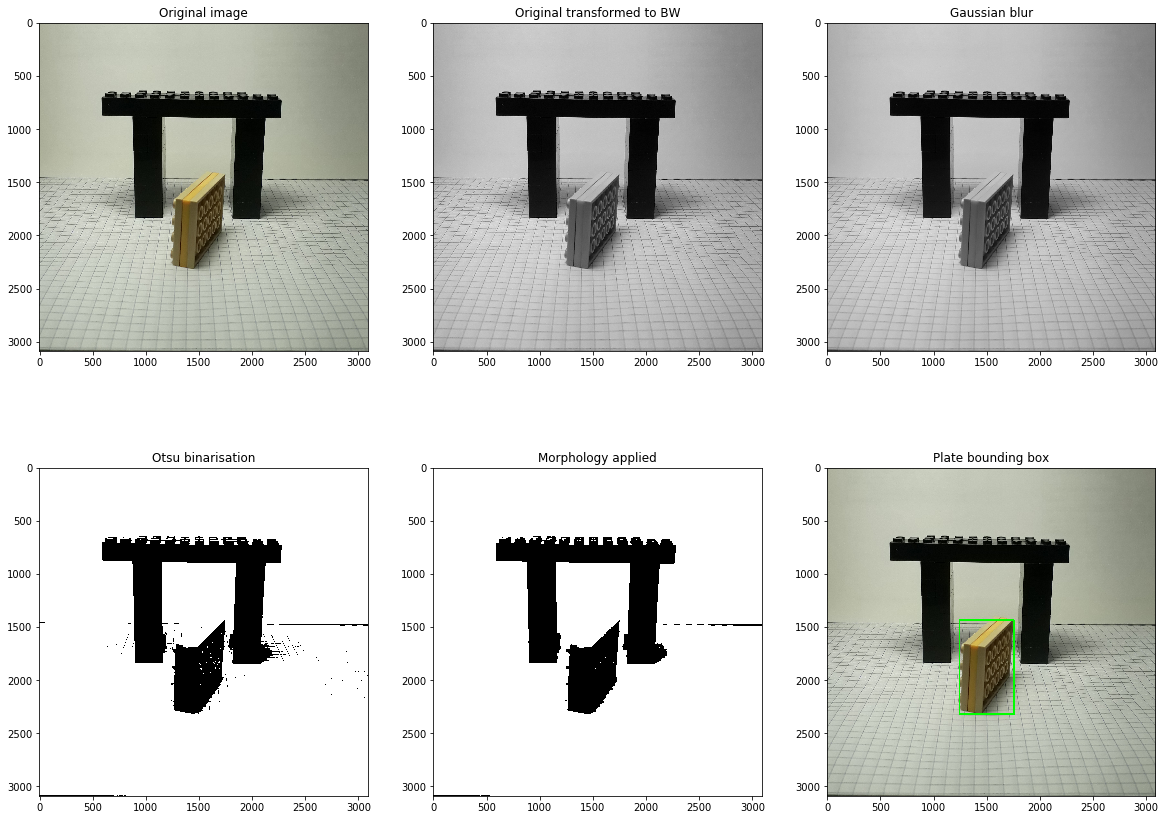

In [11]:
threshold = find_contour_proportions(os.path.abspath(os.path.join("signals_dataset", "YES(fits)", "12.jpg")), show_steps=True)

Так, например, выглядит один из случаев, где алгоритм ошибается:

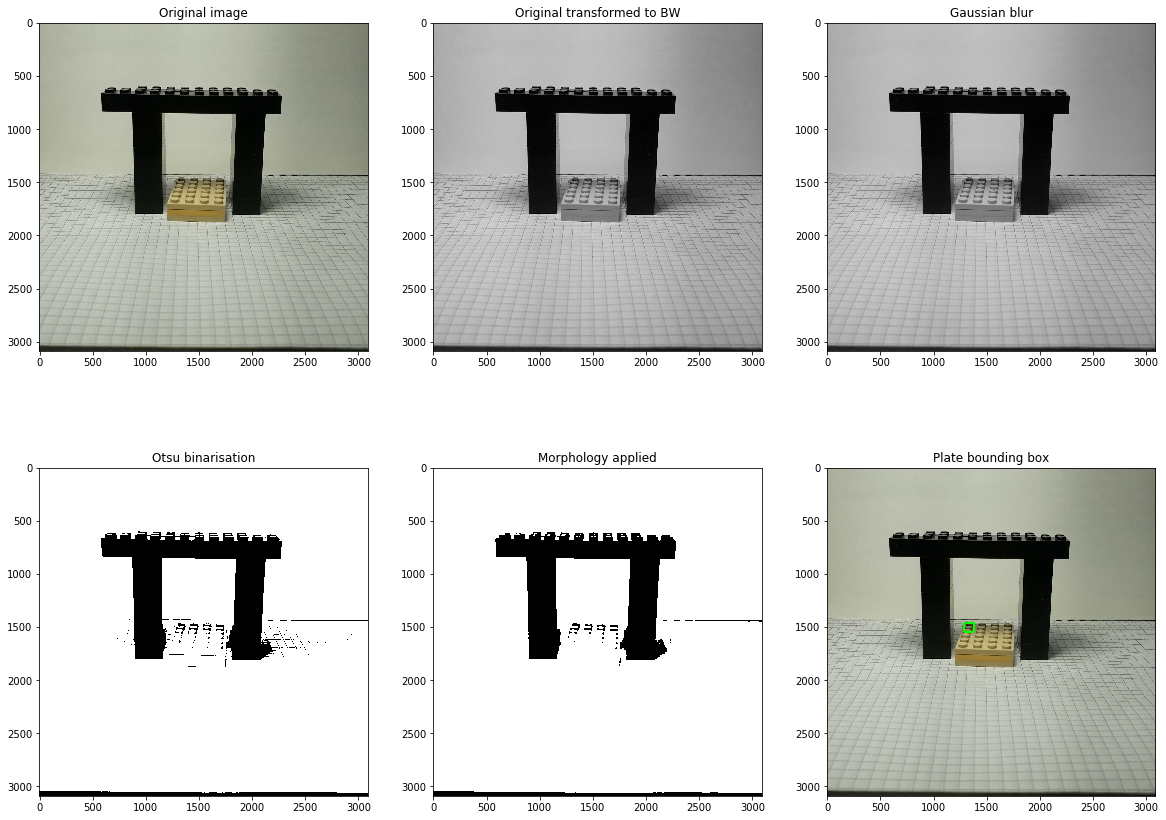

In [12]:
ratio = find_contour_proportions(os.path.abspath(os.path.join("signals_dataset", "YES(fits)", "2.jpg")), show_steps=True)